In [1]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import pickle
from watttime import WattTimeForecast, WattTimeHistorical
import data.s3 as s3u
from datetime import datetime
import seaborn as sns

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [21]:
historic_forecast_cache = pickle.loads("pjm_fore.pkl")

dfs = []
for key in historic_forecast_cache.keys():
    data = historic_forecast_cache[key]
    dfs.append(data)
df_pjm_forecast = pd.concat(dfs)
df_pjm_forecast["point_time"] = pd.to_datetime(df_pjm_forecast["point_time"])

pjm_actual = s3.load_file(file="pjm_actual.pkl")
historic_actual_cache = pickle.loads(pjm_actual)

dfs = []
for key in historic_actual_cache.keys():
    data = historic_actual_cache[key]
    dfs.append(data)
df_pjm_actual = pd.concat(dfs)

df_pjm_actual.columns = ["point_time", "value_actual"]
df_pjm_forecast.columns = ["point_time", "value_forecast", "generated_at"]
df = df_pjm_forecast.merge(df_pjm_actual, on="point_time")
df["date"] = df["point_time"].dt.date

In [36]:
df.shape
del df_pjm_forecast
del df_pjm_actual

(30909435, 3)

In [39]:
df[["value_forecast", "value_actual"]].corr(method="spearman")

,value_forecast,value_actual
value_forecast,1.00000,0.69345
value_actual,0.69345,1.00000


In [40]:
corrs = df.groupby(["date"])[["value_forecast", "value_actual"]].corr(method="spearman")
corrs = corrs[corrs["value_forecast"] < 1].reset_index()[["date", "value_forecast"]]
corrs.columns = ["date", "spearman_corr"]

In [49]:
corrs.describe()

,spearman_corr
count,473.000000
mean,0.549475
std,0.273750
min,-0.251379
25%,0.370234
50%,0.629343
75%,0.770870
max,0.938469


<Axes: ylabel='spearman_corr'>

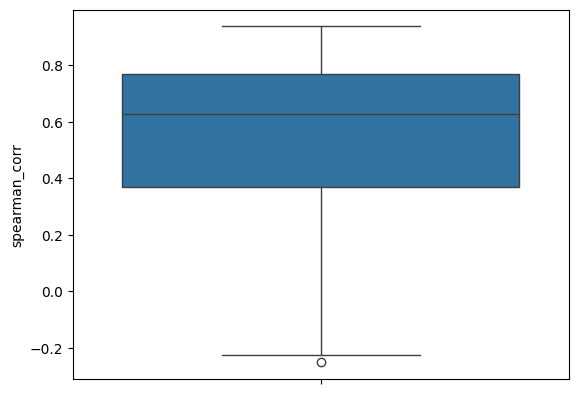

In [52]:
sns.boxplot(corrs["spearman_corr"])

In [53]:
s3.store_csvdataframe(corrs, "pjm_spearman_corrs.csv")

Successful S3 put_object response. Status - 200


In [ ]:
regions = [
    "CAISO_NORTH",
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "PJM_DC",
    "LDWP",
    "NYISO_NYC",
]

dfs = []
for r in regions:
    print(r)
    results_key = f"results/20240726_1k_synth_users_163_days_{r}.csv"
    data = s3.load_csvdataframe(file=results_key)
    data["region"] = r
    dfs.append(data)
    del data
results_data = pd.concat(dfs)

In [ ]:
results_data["ideal_difference"] = (
    results_data["simple_ideal_emissions"] - results_data["simple_actual_emissions"]
)
results_data["baseline_difference"] = (
    results_data["simple_actual_emissions"] - results_data["baseline_actual_emissions"]
)
results_data["estimated_difference"] = (
    results_data["simple_actual_emissions"] - results_data["simple_estimated_emissions"]
)
results_data["largest_possible_difference"] = (
    results_data["simple_ideal_emissions"] - results_data["baseline_actual_emissions"]
)

results_data["largest_difference_normalized"] = np.divide(
    results_data["largest_possible_difference"], results_data["power_output_rate"]
)
results_data["baseline_difference_normalized"] = np.divide(
    results_data["baseline_difference"], results_data["power_output_rate"]
)
results_data["optimization_possible"] = results_data["largest_possible_difference"] < 0

results_data["session_start_time_of_day"] = pd.to_datetime(
    results_data["session_start_time"]
).dt.time
results_data["yyyy-mm"] = results_data["distinct_dates"].str[:7]

- overall 

In [ ]:
grouped_data = (
    results_data.groupby(["distinct_dates", "region"])["largest_possible_difference"]
    .sum()
    .reset_index()
)
g = sns.FacetGrid(
    grouped_data,
    col="region",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1,
)


def plot_sum(data, **kwargs):
    ax = sns.lineplot(
        data=data, x="distinct_dates", y="largest_possible_difference", **kwargs
    )
    xticks = ax.get_xticks()
    ax.set_xticks(
        xticks[:: max(1, len(xticks) // 4)]
    )  # Reduce the number of xticks to a maximum of 4
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


g.map_dataframe(plot_sum)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Distinct Dates", "Sum of largest possible difference by date")
plt.show()

In [ ]:
# add hue of spearman corr
g = sns.FacetGrid(results_data, col="region", col_wrap=3)
g.map(sns.scatterplot, "largest_possible_difference", "baseline_difference")